In [1]:
# install libraries if not already installed, uncomment the following lines

import sys
# !{sys.executable} -m pip install opencv-python opencv-contrib-python matplotlib numpy torch torchvision pandas tqdm scikit-learn seaborn

In [2]:
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch


In [3]:
from src import dataloader as ds
from src import models as m
from src import training as t
from src import evaluation as eval


In [4]:
file_path = 'fer2013.tar.gz'
data_path = ds.unpack_tar_gz(file_path)

Target folder 'data' is not empty. Assuming the file is already unpacked.


In [5]:
# dataset is available at https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
emotion_label = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [7]:
df_mapped = df.copy()

# Map the emotion labels to their names
df_mapped['emotion'] = df_mapped['emotion'].map(emotion_label)

In [8]:
df_mapped.head()

,emotion,pixels,Usage
0,anger,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,anger,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,fear,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,sadness,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
df_mapped['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [10]:
df_mapped['emotion'].value_counts()

emotion
happiness    8989
neutral      6198
sadness      6077
fear         5121
anger        4953
surprise     4002
disgust       547
Name: count, dtype: int64

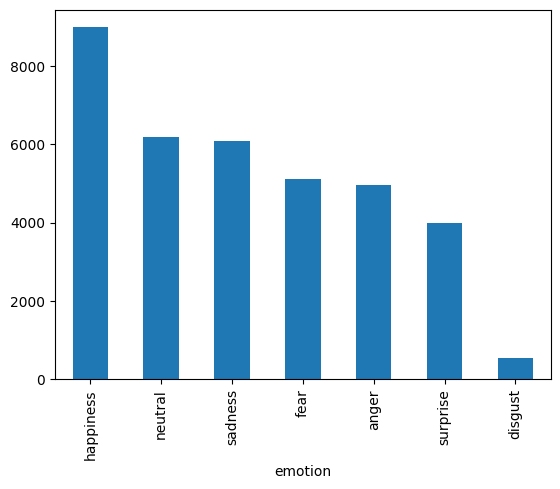

In [11]:
# plot the distribution of the emotions
df_mapped['emotion'].value_counts().plot(kind='bar')
plt.show()

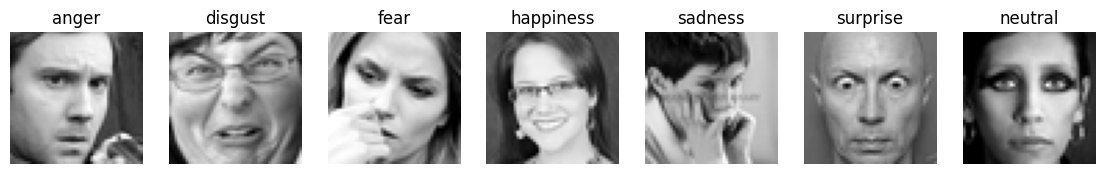

In [12]:
def pixels_to_image(pixels_str):
    pixels = np.fromstring(pixels_str, dtype=int, sep=' ')
    image = pixels.reshape(48, 48)
    return image


# plot each emotion
fig, axes = plt.subplots(1, 7, figsize=(14, 2))
for i in range(7):
    image = pixels_to_image(df[df['emotion'] == i].iloc[0]['pixels'])
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(emotion_label[i])
    axes[i].axis('off')

plt.show()

In [13]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

batch_size = 64
train_loader, valid_loader, test_loader = ds.get_data_loaders(data_path, batch_size, train_transform)

Loaded 28709 samples for mode 'train'
Loaded 3589 samples for mode 'val'
Loaded 3589 samples for mode 'test'


Validation: 100%|██████████| 57/57 [00:02<00:00, 23.41it/s, Val Loss=0.0229, Accuracy=43.2]


Epoch 1/1, Train Loss: 1.6703, Train Acc: 32.6169, Val Loss: 1.4414, Val Acc: 43.2154
Best model saved with accuracy: 43.2154 as 'bestmodels/SimpleCNN_best_model.pth'


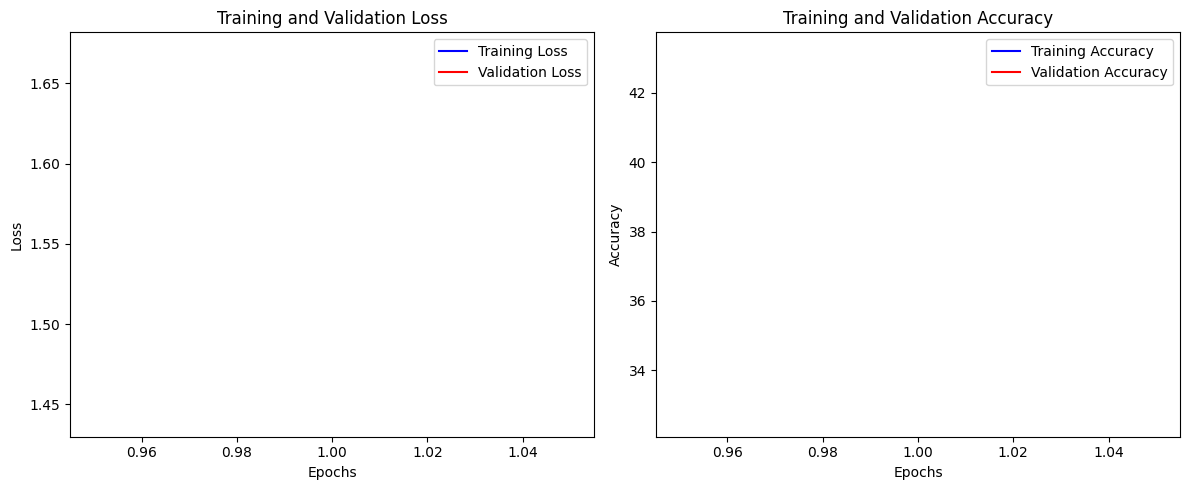

In [14]:
# Initialize model, loss function, and optimizer
model = m.SimpleCNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
t.train(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1)

Evaluating: 100%|██████████| 57/57 [00:02<00:00, 23.93it/s]


Test Loss: 1.4647, Test Accuracy: 43.3547%


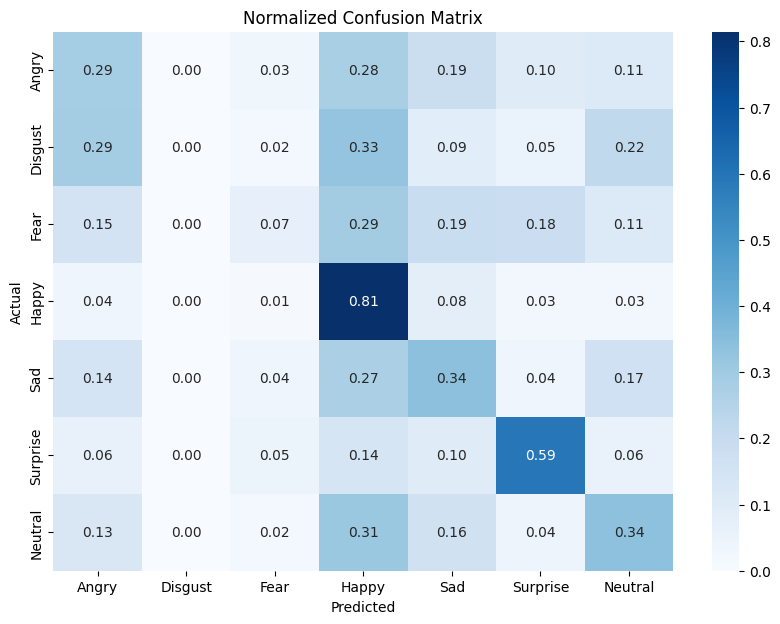

Classification Report:

              precision    recall  f1-score   support

       Angry       0.31      0.29      0.30       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.31      0.07      0.11       528
       Happy       0.50      0.81      0.62       879
         Sad       0.33      0.34      0.34       594
    Surprise       0.53      0.59      0.56       416
     Neutral       0.44      0.34      0.38       626

    accuracy                           0.43      3589
   macro avg       0.34      0.35      0.33      3589
weighted avg       0.40      0.43      0.40      3589


In [15]:
# Evaluate the model
eval.evaluate_model(model, test_loader, criterion)

Evaluating: 100%|██████████| 57/57 [00:02<00:00, 24.11it/s]


Test Loss: 1.2541, Test Accuracy: 58.2056%


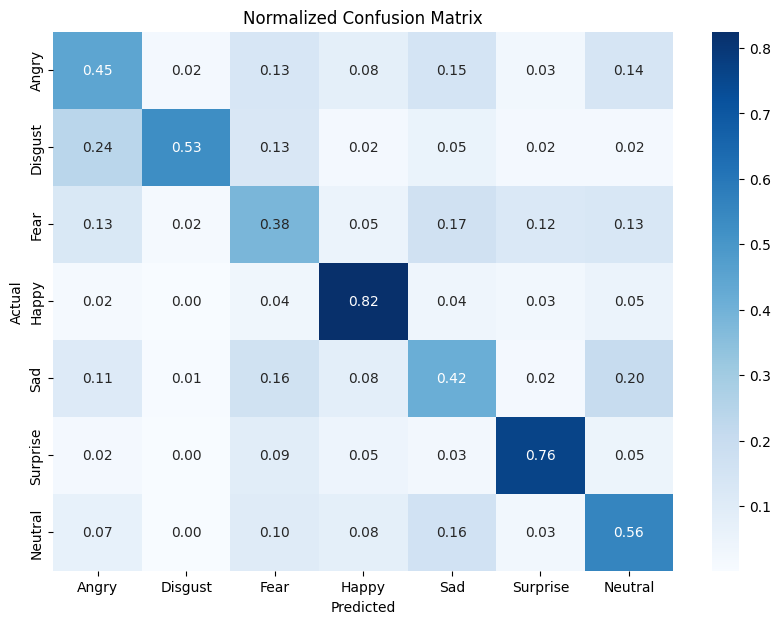

Classification Report:

              precision    recall  f1-score   support

       Angry       0.51      0.45      0.48       491
     Disgust       0.52      0.53      0.52        55
        Fear       0.40      0.38      0.39       528
       Happy       0.79      0.82      0.81       879
         Sad       0.44      0.42      0.43       594
    Surprise       0.70      0.76      0.73       416
     Neutral       0.52      0.56      0.54       626

    accuracy                           0.58      3589
   macro avg       0.55      0.56      0.56      3589
weighted avg       0.58      0.58      0.58      3589


In [16]:
# use saved model
criterion = torch.nn.CrossEntropyLoss()
model = m.load_model(m.SimpleCNN(), 'bestmodels/SimpleCNN_best_model_test.pth')
eval.evaluate_model(model, test_loader, criterion)